In [1]:
from __future__ import print_function
import torch

torch.set_default_tensor_type('torch.cuda.FloatTensor')
x = torch.rand(5, 3)
print(x)


tensor([[0.6037, 0.5431, 0.1864],
        [0.5290, 0.2139, 0.2981],
        [0.9678, 0.5666, 0.0867],
        [0.2362, 0.8536, 0.8173],
        [0.2624, 0.0129, 0.1692]])


In [2]:
torch.cuda.is_available()

True

Pytorch is working.

# Loading MNIST:

In [3]:
import torchvision as tv
mnist_train=tv.datasets.MNIST(root='./Data',train=True,download=True)
mnist_test=tv.datasets.MNIST(root='./Data',train=False,download=True)

In [4]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./Data
    Transforms (if any): None
    Target Transforms (if any): None

In [5]:
mnist_train[1]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FE3AF47FF60>,
 tensor(0, device='cpu'))

# Tranforming in tensors and grayscale:

In [6]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])

In [7]:
import torchvision as tv
mnist_train=tv.datasets.MNIST(root='./Data',train=True,download=True,transform=transform)
mnist_test=tv.datasets.MNIST(root='./Data',train=False,download=True,transform=transform)

In [8]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./Data
    Transforms (if any): Compose(
                             Grayscale(num_output_channels=1)
                             ToTensor()
                         )
    Target Transforms (if any): None

In [9]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./Data
    Transforms (if any): Compose(
                             Grayscale(num_output_channels=1)
                             ToTensor()
                         )
    Target Transforms (if any): None

# Image 0:

In [10]:
mnist_train[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [11]:
to_pil = tv.transforms.ToPILImage()
img = to_pil(mnist_train[0][0])
img

Label:

In [12]:
mnist_train[0][1].cuda()

tensor(5)

28x28 images

# Data Loaders:

In [13]:
import torch.utils.data as data

In [14]:
trainer=data.DataLoader(mnist_train,batch_size=128,shuffle=True,num_workers=8)
tester=data.DataLoader(mnist_test,batch_size=128,shuffle=True,num_workers=8)

# Network definition:

In [15]:
import torch.nn as nn
import torch.nn.functional as f

In [16]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__() #invoca o init de nn.Module
        self.conv1 = nn.Conv2d(1,32,3, padding=0)
        self.conv2 = nn.Conv2d(32,64,3, padding=0)
        self.conv3 = nn.Conv2d(64,64,3, padding=0)
        self.conv4 = nn.Conv2d(64,64,3, padding=0)
        self.drop1 = nn.Dropout(p=0.25)
        self.lin1=nn.Linear(1024,128)
        self.drop2 = nn.Dropout(p=0.5)
        self.lin2=nn.Linear(128,64)
        self.drop3 = nn.Dropout(p=0.5)
        self.lin3=nn.Linear(64,10)
        #self.soft=nn.Softmax(dim=1)
    def forward(self,x):
        x=f.relu(self.conv1(x))
        x=f.relu(self.conv2(x))
        x=f.max_pool2d(f.relu(self.conv3(x)),(2,2), padding=0)
        x=f.max_pool2d(f.relu(self.conv4(x)),(2,2), padding=0)
        x=self.drop1(x)
        #y=x.size()
        x=x.view(-1,1024)
        x=f.relu(self.lin1(x))
        x=self.drop2(x)
        x=f.relu(self.lin2(x))
        x=self.drop3(x)
        x=self.lin3(x)
       # y=x.size()
       # x=self.soft(x)
        return x
    def num_flat_features(self, x): #necessary?
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features        

In [17]:
net=Network()
print(net)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout(p=0.25)
  (lin1): Linear(in_features=1024, out_features=128, bias=True)
  (drop2): Dropout(p=0.5)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (drop3): Dropout(p=0.5)
  (lin3): Linear(in_features=64, out_features=10, bias=True)
)


In [18]:
params=list(net.parameters())
print(len(params))
print(params[0].size())

14
torch.Size([32, 1, 3, 3])


# Random test:

In [19]:
test_input=mnist_train[0][0].unsqueeze(0).cuda()

In [20]:
out=net(test_input)

In [21]:
out

tensor([[-0.0727, -0.0545, -0.0881, -0.0860,  0.0193, -0.0471, -0.0037,  0.0856,
          0.0033, -0.0571]], grad_fn=<ThAddmmBackward>)

# Training

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)#.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
device
net.to(device)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout(p=0.25)
  (lin1): Linear(in_features=1024, out_features=128, bias=True)
  (drop2): Dropout(p=0.5)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (drop3): Dropout(p=0.5)
  (lin3): Linear(in_features=64, out_features=10, bias=True)
)

In [24]:
history=[]
for epoch in range(140):  # number of epochs

    running_loss = 0.0
    count=0
    for i, data in enumerate(trainer, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)#para gpu

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        count=count+1
# print statistics
    running_loss = running_loss/count
    history.append(running_loss)
    print('epoch:',epoch,',loss:',running_loss)

print('Finished Training')


epoch: 0 ,loss: 2.303502363945121
epoch: 1 ,loss: 2.3014023212481662
epoch: 2 ,loss: 2.299924540875563
epoch: 3 ,loss: 2.298519796399928
epoch: 4 ,loss: 2.2947225575762262
epoch: 5 ,loss: 2.2762315705386813
epoch: 6 ,loss: 1.7113339578164921
epoch: 7 ,loss: 0.7942710176968117
epoch: 8 ,loss: 0.5019483613942478
epoch: 9 ,loss: 0.39291277229150473
epoch: 10 ,loss: 0.3261896855414295
epoch: 11 ,loss: 0.28034946063497684
epoch: 12 ,loss: 0.2523413136728537
epoch: 13 ,loss: 0.23057553749571222
epoch: 14 ,loss: 0.2162103899585794
epoch: 15 ,loss: 0.19531095911190707
epoch: 16 ,loss: 0.18385944628257994
epoch: 17 ,loss: 0.17294467439148217
epoch: 18 ,loss: 0.16482574786585785
epoch: 19 ,loss: 0.15337889048971856
epoch: 20 ,loss: 0.14752267029430313
epoch: 21 ,loss: 0.1435559828644559
epoch: 22 ,loss: 0.13785926135046395
epoch: 23 ,loss: 0.13185965695948615
epoch: 24 ,loss: 0.12758359852344242
epoch: 25 ,loss: 0.12295589669903459
epoch: 26 ,loss: 0.12007057356602474
epoch: 27 ,loss: 0.11400679

# Test

In [25]:
test_output=net(mnist_train[0][0].unsqueeze(0).cuda())

In [26]:
test_output

tensor([[-6.7668,  0.2746, -4.0083,  5.4703, -2.9090, 12.1799,  0.6811, -3.8624,
         -1.9489, -1.6745]], grad_fn=<ThAddmmBackward>)

In [27]:
def prediction(out):#out is the network output tensor, label is the output label
    x,y=torch.max(out,1)
    y=y.squeeze()
    return y

In [28]:
prediction(test_output)

tensor(5)

In [29]:
total=0
correct=0
for data in tester:
    inputs,labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs=net(inputs)
    predict=prediction(outputs)
    total=total+labels.size(0)
    correct=correct+(predict==labels).sum().item()
accuracy=correct/total
accuracy=accuracy*100
print('accuracy:',accuracy,'%')

accuracy: 98.48 %


# Training loss plot

In [35]:
import matplotlib.pyplot as plt
history

[2.303502363945121,
 2.3014023212481662,
 2.299924540875563,
 2.298519796399928,
 2.2947225575762262,
 2.2762315705386813,
 1.7113339578164921,
 0.7942710176968117,
 0.5019483613942478,
 0.39291277229150473,
 0.3261896855414295,
 0.28034946063497684,
 0.2523413136728537,
 0.23057553749571222,
 0.2162103899585794,
 0.19531095911190707,
 0.18385944628257994,
 0.17294467439148217,
 0.16482574786585785,
 0.15337889048971856,
 0.14752267029430313,
 0.1435559828644559,
 0.13785926135046395,
 0.13185965695948615,
 0.12758359852344242,
 0.12295589669903459,
 0.12007057356602474,
 0.1140067910652425,
 0.11116698128915926,
 0.10806241446831968,
 0.10745644853758152,
 0.10368147502734718,
 0.10053271633475575,
 0.09887406491299174,
 0.09435063388857887,
 0.09521257150957961,
 0.093058493707194,
 0.08896360733409299,
 0.08596807849337297,
 0.08808573910883113,
 0.08421567974012417,
 0.08517601951432507,
 0.0820863131544928,
 0.0794548255993105,
 0.08102365257516345,
 0.07767157485363071,
 0.077772

In [38]:
def plotData(history):
    epochs=range(len(history))
    plt.plot(epochs,history,label='Training Loss')

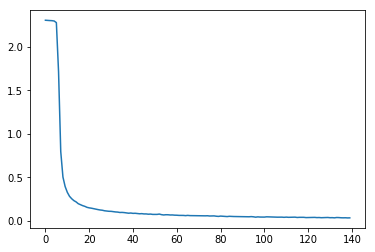

In [39]:
plotData(history)